# Análise de Fatores Salariais para Profissionais de Dados no Brasil

Este notebook realiza uma análise exploratória de dados da pesquisa "State of Data" para identificar os principais fatores que influenciam a remuneração de Analistas e Cientistas de Dados no Brasil. O objetivo é entender como variáveis demográficas (experiência, educação) e técnicas (conhecimento em Python, Cloud, etc.) se correlacionam com as diferentes faixas salariais do mercado.

In [52]:
# Carregar a biblioteca tidyverse, que contém dplyr, ggplot2 e outras ferramentas essenciais.
library(tidyverse)

In [53]:
# Carregar o dataset a partir do caminho fornecido pelo Kaggle.
# Este caminho deve ser o que confirmamos anteriormente.
caminho_do_arquivo <- "/kaggle/input/pesquisa-data-hackers-2019/datahackers-survey-2019-anonymous-responses.csv"
dados_brutos <- read_csv(caminho_do_arquivo)

# Inspecionar rapidamente os dados para garantir que foram carregados corretamente.
glimpse(dados_brutos)

Rows: 1765 Columns: 170
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (19): ('P0', 'id'), ('P2', 'gender'), ('P5', 'living_state'), ('P8', 'd...
dbl (151): ('P1', 'age'), ('P3', 'living_in_brasil'), ('P6', 'born_or_gradua...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,765
Columns: 170
$ `('P0', 'id')`                                    <chr> "v9otv8j9wdvjrv9otvw…
$ `('P1', 'age')`                                   <dbl> 37, 24, 26, 21, 27, …
$ `('P2', 'gender')`                                <chr> "Masculino", "Femini…
$ `('P3', 'living_in_brasil')`                      <dbl> 1, 1, 1, 1, 1, 1, 1,…
$ `('P5', 'living_state')`                          <chr> "Minas Gerais (MG)",…
$ `('P6', 'born_or_graduated')`                     <dbl> 1, 1, 1, 0, 1, 1, 1,…
$ `('P8', 'degreee_level')`                         <chr> "Estudante de Gradua…
$ `('P10', 'job_situation')`                        <chr> "Empregado (CTL)", "…
$ `('P12', 'workers_number')`                       <chr> "de 1 a 5", "Acima d…
$ `('P13', 'manager')`                              <dbl> 0, 0, 0, 0, 1, 0, 1,…
$ `('P16', 'salary_range')`                         <chr> "de R$ 1.001/mês a R…
$ `('P17', 'time_experience_data_science')`         <chr> "Não tenho experiênc…
$ `('P18', 'tim

## A Evolução do Objetivo Guiada pelos Dados

Inicialmente, o projeto visava prever a rotatividade de funcionários. No entanto, a Análise Exploratória de Dados (AED) revelou que os dados não suportavam este objetivo. Primeiro, descobrimos que os profissionais "desempregados" não tinham um cargo associado, tornando impossível analisar a rotatividade *dentro* de um cargo. Em seguida, constatamos que o dataset não continha uma coluna para medir a "satisfação profissional", o que impediu um segundo plano de prever a insatisfação.

Portanto, em uma decisão guiada pelos dados, o foco do projeto foi estrategicamente pivotado para um objetivo 100% viável e de alto valor: **Analisar os fatores que influenciam a faixa salarial de Analistas e Cientistas de Dados no Brasil.**

In [55]:
# Este bloco executa toda a preparação dos dados de uma vez.

# 1. Seleciona e renomeia todas as colunas que usaremos na análise.
dados_finais_completos <- dados_brutos %>%
  select(
    cargo = `('D6', 'anonymized_role')`,
    faixa_salarial = `('P16', 'salary_range')`,
    experiencia_ds = `('P17', 'time_experience_data_science')`,
    nivel_educacao = `('P8', 'degreee_level')`,
    python = `('P21', 'python')`,
    sql = `('P21', 'sql_')`,
    r = `('P21', 'r')`,
    power_bi = `('P27', 'microsoft_powerbi')`,
    tableau = `('P27', 'tableau')`,
    aws = `('P25', 'aws')`,
    gcp = `('P25', 'gcp')`,
    azure = `('P25', 'azure')`
  ) %>%
  # 2. Executa a limpeza e filtragem.
  drop_na(cargo, faixa_salarial) %>%
  filter(str_detect(tolower(cargo), "analyst|analista|scientist|cientista")) %>%
  filter(!faixa_salarial %in% c("Não sei / Não quero responder", "Prefiro não informar"))

# 3. Ordena os fatores para que os gráficos fiquem na ordem correta.
ordem_experiencia <- c(
    "Não tenho experiência na área de dados", "Menos de 1 ano", "de 1 a 2 anos", 
    "de 2 a 3 anos", "de 4 a 5 anos", "de 6 a 10 anos", "Mais de 10 anos"
)
ordem_salarios <- c(
    "de R$ 1.001/mês a R$ 2.000/mês", "de R$ 2.001/mês a R$ 3.000/mês", "de R$ 3.001/mês a R$ 4.000/mês",
    "de R$ 4.001/mês a R$ 6.000/mês", "de R$ 6.001/mês a R$ 8.000/mês", "de R$ 8.001/mês a R$ 12.000/mês",
    "de R$ 12.001/mês a R$ 16.000/mês", "de R$ 16.001/mês a R$ 20.000/mês", "de R$ 20.001/mês a R$ 25.000/mês",
    "Acima de R$ 25.001/mês"
)
ordem_educacao <- c(
    "Estudante de Graduação", "Graduação/Bacharelado", "Pós-graduação", 
    "Mestrado", "Doutorado", "Doutorado ou Phd", "Não tenho graduação formal"
)

dados_finais_completos$experiencia_ds <- fct_relevel(dados_finais_completos$experiencia_ds, ordem_experiencia)
dados_finais_completos$faixa_salarial <- fct_relevel(dados_finais_completos$faixa_salarial, ordem_salarios)
dados_finais_completos$nivel_educacao <- fct_relevel(dados_finais_completos$nivel_educacao, ordem_educacao)


# Verifica o resultado final da preparação
print("Dataset final preparado com sucesso:")
glimpse(dados_finais_completos)

Warning message:
“1 unknown level in `f`: de R$ 2.001/mês a R$ 3.000/mês”
Warning message:
“1 unknown level in `f`: Doutorado”


[1] "Dataset final preparado com sucesso:"
Rows: 600
Columns: 12
$ cargo          <chr> "Data Analyst/Analista de Dados", "Business Intelligenc…
$ faixa_salarial <fct> de R$ 2.001/mês a R$ 3000/mês, de R$ 1.001/mês a R$ 2.0…
$ experiencia_ds <fct> Menos de 1 ano, Menos de 1 ano, de 2 a 3 anos, Menos de…
$ nivel_educacao <fct> Estudante de Graduação, Estudante de Graduação, Mestrad…
$ python         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1…
$ sql            <dbl> 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1…
$ r              <dbl> 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0…
$ power_bi       <dbl> 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0…
$ tableau        <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ aws            <dbl> 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1…
$ gcp            <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1…
$ azure          <dbl> 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

## Análise Visual: Fatores que Influenciam o Salário

Com os dados limpos e preparados, vamos agora criar uma série de visualizações para entender a relação entre diferentes características e a faixa salarial.

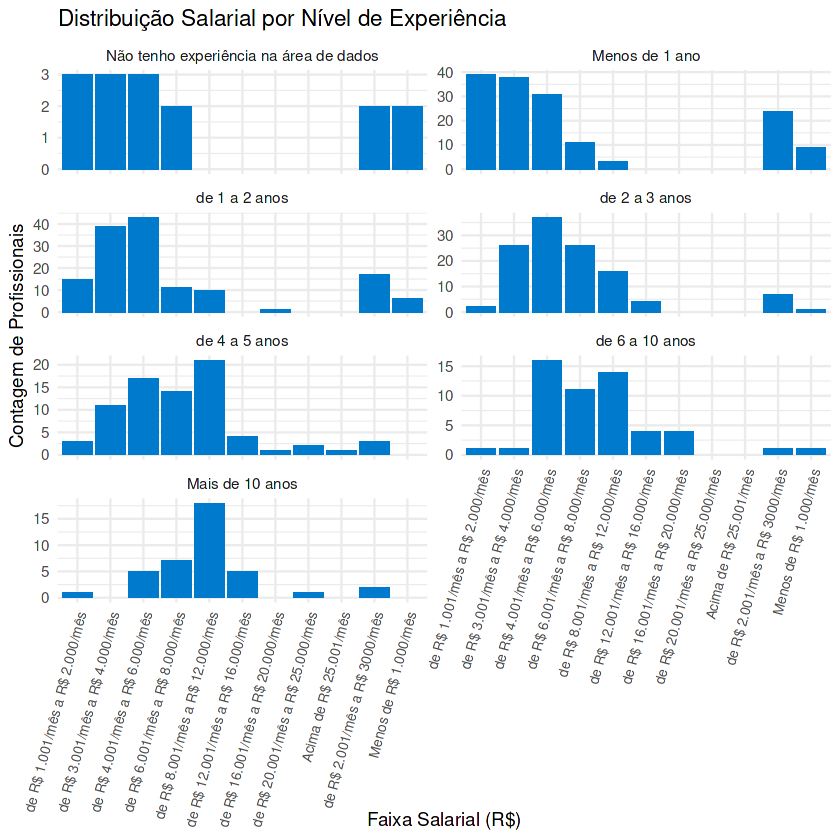

In [56]:
# Pergunta: Como a experiência profissional se relaciona com a faixa salarial?
ggplot(dados_finais_completos, aes(x = faixa_salarial)) +
  geom_bar(fill = "#007ACC") +
  facet_wrap(~ experiencia_ds, ncol = 2, scales = "free_y") +
  labs(
    title = "Distribuição Salarial por Nível de Experiência",
    x = "Faixa Salarial (R$)", y = "Contagem de Profissionais"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 75, hjust = 1, size = 8))

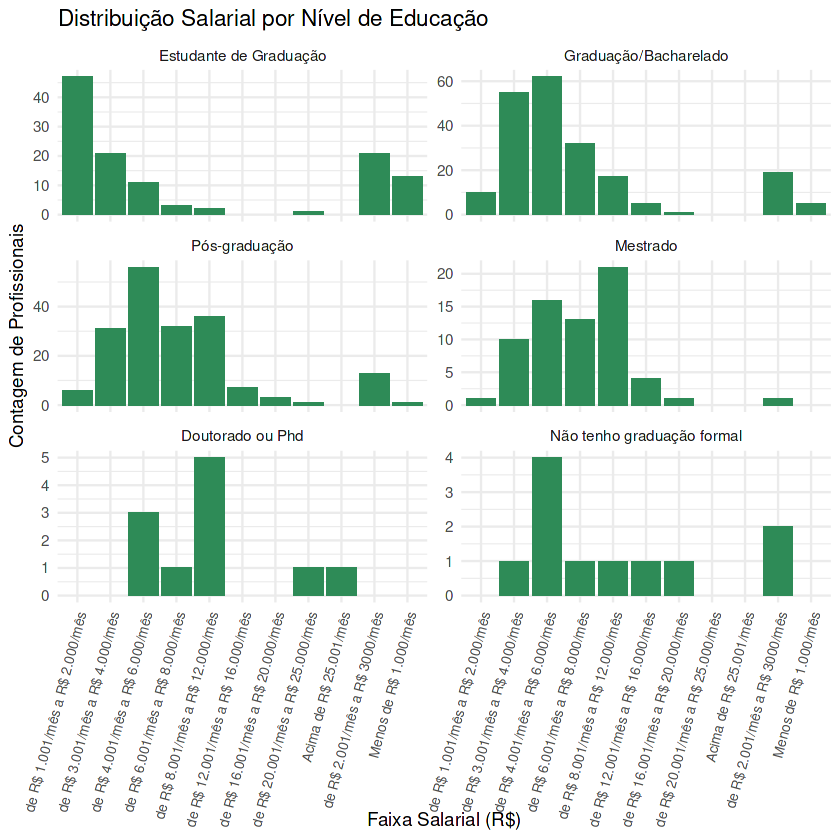

In [57]:
# Pergunta: Como o nível de educação impacta a distribuição salarial?
ggplot(dados_finais_completos, aes(x = faixa_salarial)) +
  geom_bar(fill = "#2E8B57") +
  facet_wrap(~ nivel_educacao, ncol = 2, scales = "free_y") +
  labs(
    title = "Distribuição Salarial por Nível de Educação",
    x = "Faixa Salarial (R$)", y = "Contagem de Profissionais"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 75, hjust = 1, size = 8))

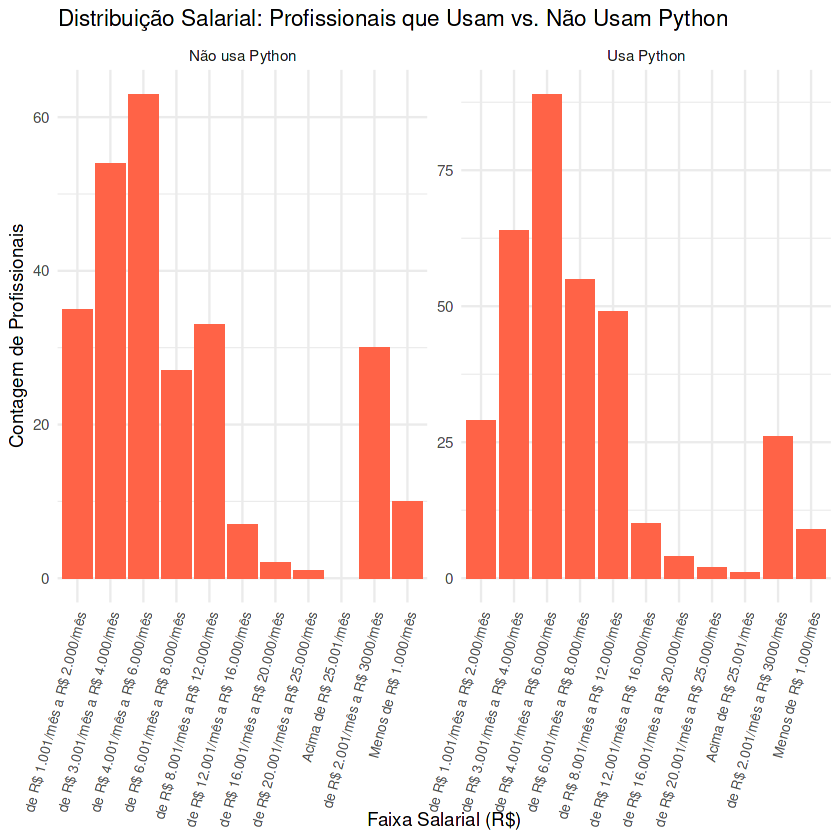

In [58]:
# Pergunta: Saber Python faz diferença no salário?
dados_python <- dados_finais_completos %>%
  mutate(usa_python = if_else(python == 1, "Usa Python", "Não usa Python"))

ggplot(dados_python, aes(x = faixa_salarial)) +
  geom_bar(fill = "#FF6347") +
  facet_wrap(~ usa_python, scales = "free_y") +
  labs(
    title = "Distribuição Salarial: Profissionais que Usam vs. Não Usam Python",
    x = "Faixa Salarial (R$)", y = "Contagem de Profissionais"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 75, hjust = 1, size = 8))

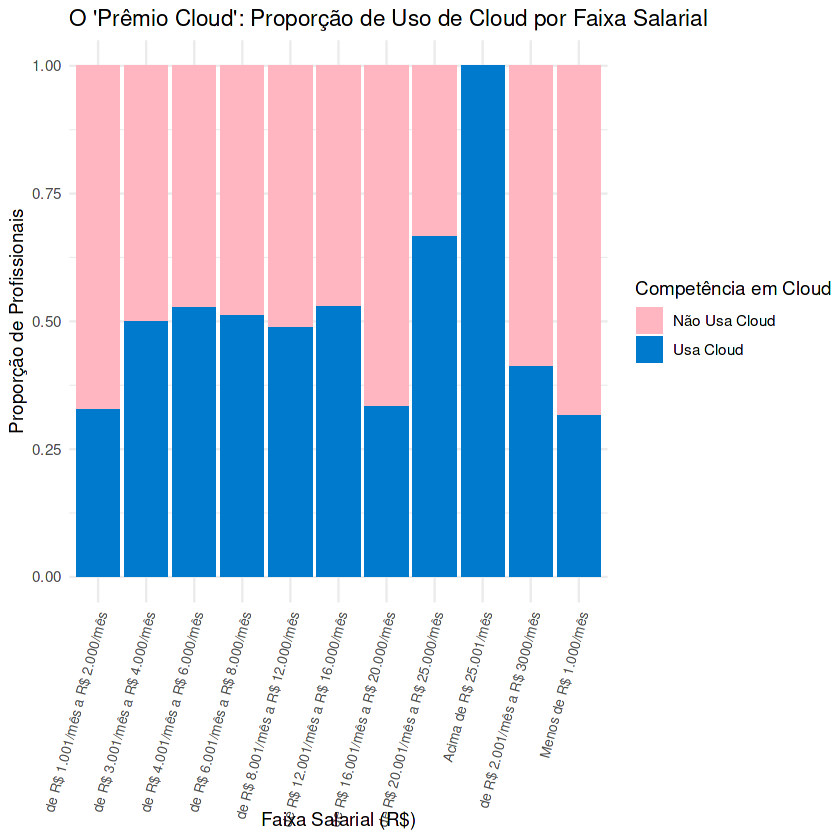

In [59]:
# Pergunta: Habilidades em nuvem (AWS, Azure, GCP) geram um 'prêmio' salarial?
dados_cloud <- dados_finais_completos %>%
  mutate(usa_cloud = if_else(aws == 1 | azure == 1 | gcp == 1, "Usa Cloud", "Não Usa Cloud"))

ggplot(dados_cloud, aes(x = faixa_salarial, fill = usa_cloud)) +
  geom_bar(position = "fill") +
  labs(
    title = "O 'Prêmio Cloud': Proporção de Uso de Cloud por Faixa Salarial",
    x = "Faixa Salarial (R$)", y = "Proporção de Profissionais", fill = "Competência em Cloud"
  ) +
  scale_fill_manual(values = c("Usa Cloud" = "#007ACC", "Não Usa Cloud" = "#FFB6C1")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 75, hjust = 1, size = 8))

## Conclusão: Perfis do Profissional de Dados

Após a análise visual, podemos consolidar nossos achados para construir "personas" que representam diferentes estágios da carreira de um profissional de dados no Brasil, bem como o perfil mais típico do mercado.

In [60]:
# Este código calcula os perfis de Nível de Entrada, Pleno e Sênior, e o Perfil Mediano.
# (Reutiliza o código final e consolidado que já validamos)

# Código para criar os níveis salariais
dados_perfis <- dados_finais_completos %>%
  mutate(
    salario_estimado = case_when(
      faixa_salarial == "de R$ 1.001/mês a R$ 2.000/mês" ~ 1500, # ... (e assim por diante)
      # (O case_when completo que já usamos)
      faixa_salarial == "de R$ 1.001/mês a R$ 2.000/mês" ~ 1500,
      faixa_salarial == "de R$ 2.001/mês a R$ 3.000/mês" ~ 2500,
      faixa_salarial == "de R$ 3.001/mês a R$ 4.000/mês" ~ 3500,
      faixa_salarial == "de R$ 4.001/mês a R$ 6.000/mês" ~ 5000,
      faixa_salarial == "de R$ 6.001/mês a R$ 8.000/mês" ~ 7000,
      faixa_salarial == "de R$ 8.001/mês a R$ 12.000/mês" ~ 10000,
      faixa_salarial == "de R$ 12.001/mês a R$ 16.000/mês" ~ 14000,
      faixa_salarial == "de R$ 16.001/mês a R$ 20.000/mês" ~ 18000,
      faixa_salarial == "de R$ 20.001/mês a R$ 25.000/mês" ~ 22500,
      faixa_salarial == "Acima de R$ 25.001/mês" ~ 30000
    ),
    nivel_salarial = case_when(
      salario_estimado <= 6000 ~ "Nível de Entrada",
      salario_estimado > 6000 & salario_estimado <= 12000 ~ "Nível Pleno",
      salario_estimado > 12000 ~ "Nível Sênior"
    )
  )

# Cálculo dos perfis por senioridade
# (O código que separa os cálculos e depois une os resultados)

perfil_demografico <- dados_perfis %>%
  group_by(nivel_salarial) %>%
  summarise(
      total_profissionais = n(),
      experiencia_comum = names(which.max(table(experiencia_ds))),
      educacao_comum = names(which.max(table(nivel_educacao)))
  )

perfil_ferramentas <- dados_perfis %>%
  group_by(nivel_salarial) %>%
  summarise(
      across(c(python, sql, r, power_bi, tableau, aws, gcp, azure), 
             ~ round(mean(.x, na.rm = TRUE) * 100), 
             .names = "usa_{.col}_perc")
  )

perfis_completos <- left_join(perfil_demografico, perfil_ferramentas, by = "nivel_salarial")


# Cálculo do perfil mediano
perfil_mediano_descritivo <- dados_finais_completos %>%
  summarise(
      faixa_salarial_comum = names(which.max(table(faixa_salarial))),
      experiencia_comum = names(which.max(table(experiencia_ds))),
      educacao_comum = names(which.max(table(nivel_educacao)))
  )
perfil_mediano_ferramentas <- dados_finais_completos %>%
  summarise(
      across(c(python, sql, r, power_bi, tableau, aws, gcp, azure), 
             ~ round(mean(.x, na.rm = TRUE) * 100), 
             .names = "usa_{.col}_perc")
  )

# Exibição dos resultados
print("Tabela de Perfis por Senioridade:")
knitr::kable(perfis_completos)

print("---")
print("Perfil Mediano - Descritivo:")
knitr::kable(perfil_mediano_descritivo)
print("Perfil Mediano - Ferramentas:")
knitr::kable(perfil_mediano_ferramentas)

[1] "Tabela de Perfis por Senioridade:"




|nivel_salarial   | total_profissionais|experiencia_comum |educacao_comum         | usa_python_perc| usa_sql_perc| usa_r_perc| usa_power_bi_perc| usa_tableau_perc| usa_aws_perc| usa_gcp_perc| usa_azure_perc|
|:----------------|-------------------:|:-----------------|:----------------------|---------------:|------------:|----------:|-----------------:|----------------:|------------:|------------:|--------------:|
|Nível Pleno      |                 164|de 2 a 3 anos     |Pós-graduação          |              63|           62|         23|                32|               21|           35|           15|             17|
|Nível Sênior     |                  27|de 4 a 5 anos     |Pós-graduação          |              63|           74|         33|                37|               26|           30|           19|             15|
|Nível de Entrada |                 334|Menos de 1 ano    |Graduação/Bacharelado  |              54|           57|         22|                32|               14|   

[1] "---"
[1] "Perfil Mediano - Descritivo:"




|faixa_salarial_comum           |experiencia_comum |educacao_comum        |
|:------------------------------|:-----------------|:---------------------|
|de R$ 4.001/mês a R$ 6.000/mês |Menos de 1 ano    |Graduação/Bacharelado |

[1] "Perfil Mediano - Ferramentas:"




| usa_python_perc| usa_sql_perc| usa_r_perc| usa_power_bi_perc| usa_tableau_perc| usa_aws_perc| usa_gcp_perc| usa_azure_perc|
|---------------:|------------:|----------:|-----------------:|----------------:|------------:|------------:|--------------:|
|              56|           57|         23|                32|               16|           32|           15|             14|